This notebooks checks how similarity of hashes is preserved in popular vs unpopular movies

In [11]:
N = 800
num_bits = 512

In [12]:
from random import sample
from time import time
from pickle import dump, load
import seaborn as sns


from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_similarity_score
from datasketch import WeightedMinHash, WeightedMinHashGenerator
from scipy.stats import describe

In [13]:
df = pd.read_csv('./dataset.csv', index_col=0)
df_h = pd.read_csv('./neural_hashes.csv', index_col=0)
with open('./sims.pkl', 'rb') as f:
    sims_train_set = load(f)

In [14]:
# test on data that has not been used during training
training_pairs = set()
for movie_name in sims_train_set:
    for pair_type in sims_train_set[movie_name]:
        for movie_subname in sims_train_set[movie_name][pair_type]:
            # for sake of bidirectionality
            training_pairs.add((movie_name, movie_subname))
            training_pairs.add((movie_subname, movie_name))

In [15]:
# generate combinations of movie titles for testing
titles = set(df.index.values)

# genrate weighted minhash gen
wmg = WeightedMinHashGenerator(len(df.columns), sample_size=32)

In [16]:
popularity_columns = ['num_voted_users', 'num_user_for_reviews']

In [17]:
test_sets = dict()
for col in popularity_columns:
    test_sets[col] = dict()
    test_sets[col]['popular'] = list(df[df[col] > df[col].quantile(0.8)].index.values)
    test_sets[col]['unpopular'] = list(df[df[col] < df[col].quantile(0.2)].index.values)

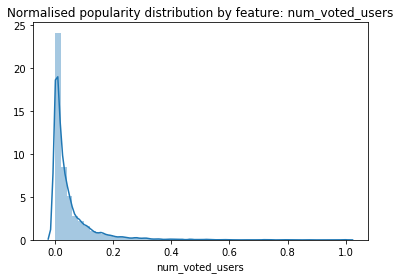

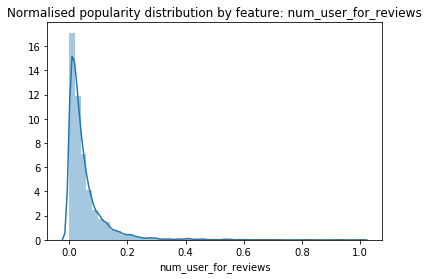

In [18]:
for i, col in enumerate(popularity_columns):
    plt.figure(i)
    sns.distplot(df[col])
    plt.title(f'Normalised popularity distribution by feature: {col}')
    plt.savefig(f'{col}-dist.png')

In [19]:
pairs = {col: {} for col in test_sets.keys()}
for feature in test_sets.keys():
    print(f'Computing score by popularity via {feature} column')
    # generate random, shuffled combinations (can't use itertools.combinations for this)
    pop_combs = set()
    unpop_combs = set()
    while len(pop_combs) < N:
        pop_pair = tuple(sample(test_sets[feature]['popular'], 2))
        if pop_pair not in training_pairs:
            pop_combs.add(pop_pair)
            
    while len(unpop_combs) < N: 
        unpop_pair = tuple(sample(test_sets[feature]['unpopular'], 2))
        if unpop_pair not in training_pairs:
            unpop_combs.add(unpop_pair)
    
    print(f'Popular combs by {feature}: {len(pop_combs)}')
    print(f'Unpopular combs by {feature}: {len(unpop_combs)}')
    pairs[feature]['popular'] = pop_combs
    pairs[feature]['unpopular'] = unpop_combs

Computing score by popularity via num_voted_users column
Popular combs by num_voted_users: 800
Unpopular combs by num_voted_users: 800
Computing score by popularity via num_user_for_reviews column
Popular combs by num_user_for_reviews: 800
Unpopular combs by num_user_for_reviews: 800


testing feature: num_voted_users
testing popular movies
Distribution of similarity for popular by num_voted_users


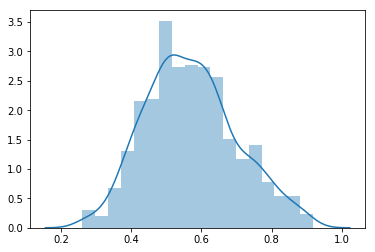

testing unpopular movies
Distribution of similarity for unpopular by num_voted_users


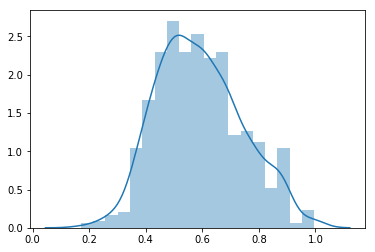

testing feature: num_user_for_reviews
testing popular movies
Distribution of similarity for popular by num_user_for_reviews


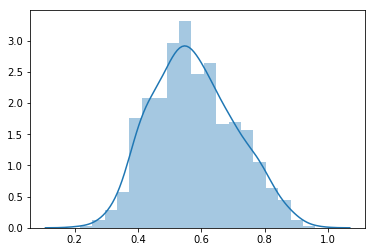

testing unpopular movies
Distribution of similarity for unpopular by num_user_for_reviews


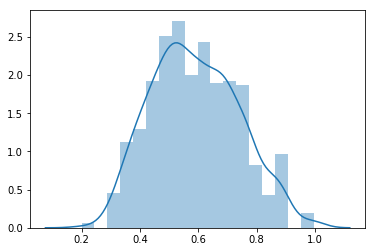

Computing similarity took 48.789342403411865 seconds.


{'num_voted_users': {'popular': {'mae_minhash': 0.07590164241741831,
   'mae_model': 0.11855110601613013},
  'unpopular': {'mae_minhash': 0.08406489669318339,
   'mae_model': 0.13019116656843285}},
 'num_user_for_reviews': {'popular': {'mae_minhash': 0.07966369845464516,
   'mae_model': 0.11907676470333768},
  'unpopular': {'mae_minhash': 0.08510031164266184,
   'mae_model': 0.12460237213651115}}}

In [20]:
# we want MAE
start = time()
results = {feature: {} for feature in pairs.keys()}
for feature in pairs.keys():
    print(f'testing feature: {feature}')
    for popularity in pairs[feature].keys():
        print(f'testing {popularity} movies')
        gt_arr = np.zeros((N,))
        model_arr = np.zeros((N,))
        minhash_arr = np.zeros((N,))
        
        for i, comb in enumerate(pairs[feature][popularity]):
            title_x, title_y= comb
            arr_x = df.loc[title_x].values
            arr_y = df.loc[title_y].values
            
            # ground truth
            gt_arr[i] = cosine_similarity(
                arr_x.reshape(1, -1),
                arr_y.reshape(1, -1))[0][0]
            
            # minhash from datasketch
            m_x = wmg.minhash(arr_x)
            m_y = wmg.minhash(arr_y)
            minhash_arr[i] = m_x.jaccard(m_y)
            
            # model
            hash_x = df_h.loc[title_x].values
            hash_y = df_h.loc[title_y].values
            model_arr[i] = jaccard_similarity_score(
                hash_x.reshape(1, -1),
                hash_y.reshape(1, -1))
            
        print(f'Distribution of similarity for {popularity} by {feature}')
        plt.figure()
        sns.distplot(gt_arr)
        plt.show()
        
        mae_minhash = (np.abs(gt_arr - minhash_arr)).mean()
        mae_model = (np.abs(gt_arr - model_arr)).mean()
        results[feature][popularity] = {
            'mae_minhash': mae_minhash,
            'mae_model': mae_model
        }


print(f'Computing similarity took {time() - start} seconds.')
results
        